In [1]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
from torch import Tensor
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from typing import Any, Callable, List, Optional, Type, Union
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import wandb
from datetime import datetime
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.models import resnet101, ResNet101_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

# from pythae.models import AE, AEConfig, AutoModel
# from pythae.trainers import BaseTrainerConfig
# from pythae.pipelines.training import TrainingPipeline
# from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
# from pythae.data.datasets import DatasetOutput
# from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['WANDB_DATA_DIR'] = '/hps/nobackup/birney/users/esther/wandb/artifacts/staging/'
os.environ['WANDB_TIMEOUT'] = '120'
os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')
model_dir = '/hps/nobackup/birney/users/esther/medaka-img/models/'

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

## Build the CNN-based autoencoder
Feed a 224x224 image into the autoencoder

In [7]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        x = self.deconv1(x)
        x = self.deconv2(x.reshape(x.shape[0], 1024, 28, 28))
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return x

In [8]:
model = AutoEncoderConv((1, 224, 224), 128)

summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 1, 224, 224]          --
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        2,176
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28]        

Check masks of original vs generated images from previous runs

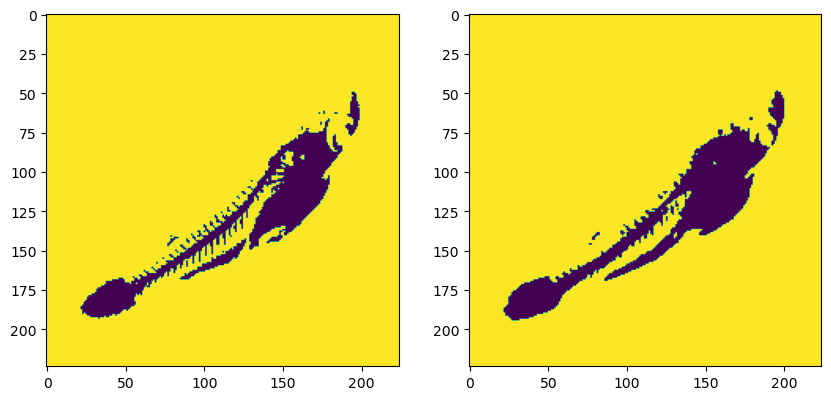

In [11]:
original_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/original-img-gentle-breeze-45-epoch700.png")
reconstructed_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/validation-img-gentle-breeze-45-epoch700.png")

original_img = MinMaxScaling()(original_img)[:,:,0] < 0.19
reconstructed_img = MinMaxScaling()(reconstructed_img)[:,:,0] < 0.19

original_img = original_img.astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img)
ax[1].imshow(reconstructed_img)
plt.show()

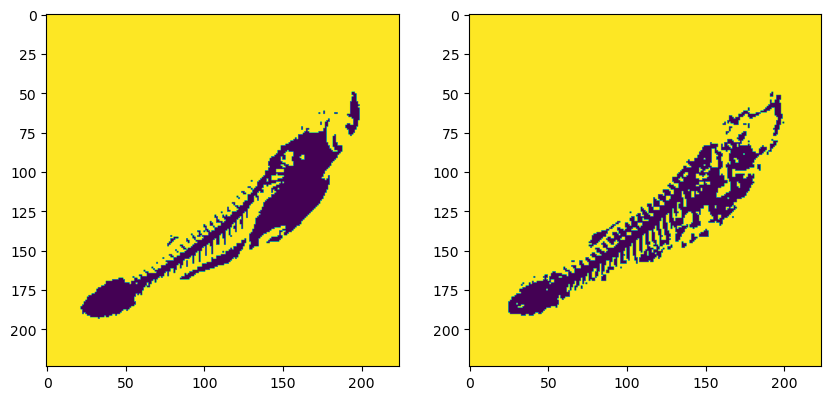

[1 2]
[0. 1.]
[0 1]


In [46]:
# load ilastik masks
ilastik_mask = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/train_ilastik-masks-05112024/PLATE 18 F2 VC_ Female 14-2 F14 x Male 60-1 F14_B8_Simple Segmentation.tif")
# ilastik_mask = MinMaxScaling()(ilastik_mask)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img)
ax[1].imshow(mask_transform(ilastik_mask).permute(1, 2, 0))
plt.show()

print(np.unique(ilastik_mask))
print(np.unique(mask_transform(ilastik_mask)))
print(np.unique(original_img))

PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif
105
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


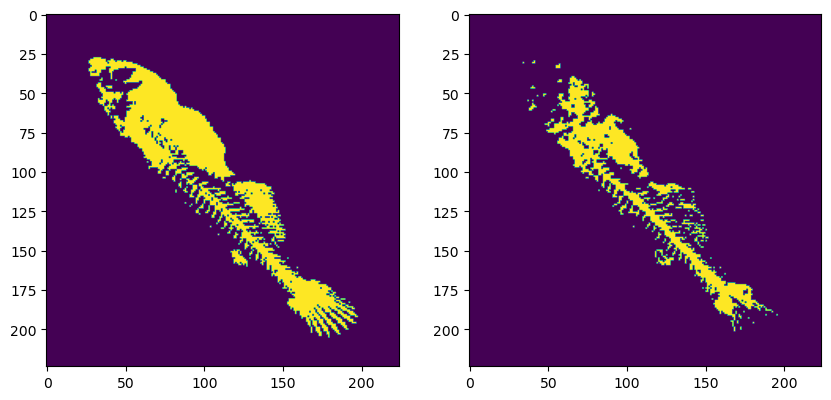

[False  True]


In [158]:
# original_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/original-img-gentle-breeze-45-epoch700.png")
# ilastik_mask = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/train_ilastik-masks-05112024/PLATE 18 F2 VC_ Female 14-2 F14 x Male 60-1 F14_B8_Simple Segmentation.tif")
original_img, original_img_name, ilastik_mask = dataset[0]
print(original_img_name)

angle = random.randint(-180, 180)
print(angle)

print(original_img.shape)
print(ilastik_mask.shape)

original_img2 = TF.rotate(original_img, angle)
ilastik_mask2 = TF.rotate(ilastik_mask, angle)

print(type(original_img2))
print(type(ilastik_mask2))

ilastik_mask2 = ilastik_mask2.permute(1, 2, 0)
ilastik_mask2 = (ilastik_mask2 < 0.005) & (ilastik_mask2 > 0)

# plt.imshow(original_img2)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img2.cpu().permute(1, 2, 0)[:,:,0] > 0.19)
ax[1].imshow(ilastik_mask2)
plt.show()

print(np.unique(ilastik_mask2))

In [32]:
np.unique(mask_transform(ilastik_mask))

array([0.00392157, 0.00392157, 0.00392157, ..., 0.00784314, 0.00784314,
       0.00784314], dtype=float32)

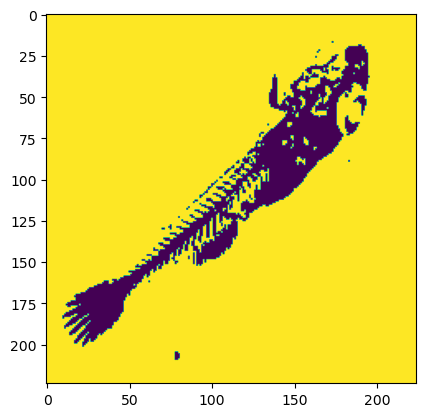

In [72]:
test_img = get_image_by_name(dataset, "PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_B05.tif")
test_img = test_img.cpu().numpy().transpose(1, 2, 0)
test_img = MinMaxScaling()(test_img)[:,:,0] < 0.19

plt.imshow(test_img)

## Configure wandb

In [26]:
config = dict(
    epochs=101,
    batch_size=16,
    learning_rate=0.00001,
    dataset="medaka-img-2024-10-03",
    architecture="Convolutional NN Autoencoder - train from scratch, custom mse loss",
    model="convnet-ae",
    train_img_rotation=10, # How much to rotate images during training
    ckpt_freq=50, # How often to save model checkpoints
    ckpt_dir=model_dir, # Directory to save model checkpoints
    reconstruction_table_freq=50, # How often to save reconstruction table

)

print(config['batch_size'])

16


## Load medaka data

In [12]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
class MinMaxScalingBinary:
    def __call__(self, tensor):
        img = (tensor - tensor.min()) / (tensor.max() - tensor.min())
        binary_img = (img > 0.5).float()
        return binary_img

In [13]:
def mask_transform(resize_shape=(224, 224)):
    transformations = [
        transforms.ToTensor(),
        transforms.Lambda(
            lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)),
        transforms.Resize(resize_shape),
        # MinMaxScalingBinary()
    ]

    return transforms.Compose(transformations)

In [14]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.Resize((224, 224)),
    # transforms.Resize((979, 979)), # resize to 979x979 to give 490x490 after first conv
    # transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

Flip all left-facing images to the right within the MedakaDataset class

In [114]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [128]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform
        self.mask_transform = mask_transform((224, 224))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_base_name = os.path.splitext(img_name)[0]
        img_path = f'{self.src_dir}/raw_images/{img_name}'
        mask_path = f'{self.src_dir}/train_ilastik-masks-05112024/{img_base_name}_Simple Segmentation.tif'
                
        image = ski.io.imread(img_path)
        mask = ski.io.imread(mask_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)
            mask = self.mask_transform(mask)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        ### Manual adjustments to odd images in training set
        # Manually flip the images where the fish head is facing down
        if img_name in ['PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_H7.tif']:
            image = transforms.functional.hflip(image)
            image = transforms.functional.vflip(image)
            mask = transforms.functional.hflip(mask)
            mask = transforms.functional.vflip(mask)

        # These fish are horizontal in the original image, so rotate them 45 degrees
        if img_name in ['PLATE 2 F2 VC_Male 95-1 F14 x Female 129-1 F14_D5.tif',
                        'PLATE 6 F2 VC_ Female 95-1 F14 x Male 72-1 F14_G5.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G1.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G4.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G9.tif']:
            image = transforms.functional.rotate(image, 45)
            mask = transforms.functional.rotate(mask, 45)

        return image.to(device), img_name, mask # in script cannot use .to(device) here

In [142]:
# Load dataset
dataset = MedakaDataset(csv_file='train_set_2024-10-03 copy.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/', 
                                transform=transform)

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

print(f"Total training set length: {len(dataset)}")
print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

test_dataset = MedakaDataset(csv_file='test_set_2024-10-03 copy.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)
print("Test length: ", len(test_dataset))

Total training set length: 1109
Train length: 887
Validation length: 222
Test length:  1008


/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [119]:
# Get image by img_name
def get_image_by_name(dataset, img_name):
    for i in range(len(dataset)):
        if dataset[i][1] == img_name:
            return dataset[i][0]

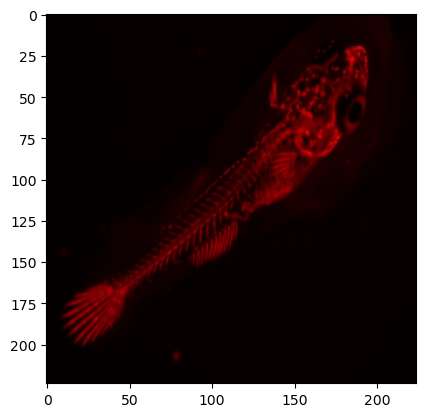

In [120]:
test_img = get_image_by_name(dataset, "PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_B05.tif")

plt.imshow(test_img.cpu().numpy().transpose(1, 2, 0))

Implement checkpointing

In [47]:
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

## Create training loop

In [48]:
random_trans = transforms.Compose([
        transforms.RandomRotation(config['train_img_rotation'])
    ])

In [49]:
import torch.nn.functional as F

class CustomMSELoss:
    def __call__(self, recon_x, x):
        MSE = F.mse_loss(
            recon_x.reshape(x.shape[0], -1), x.reshape(x.shape[0], -1), reduction="none"
        ).sum(dim=-1)
        return MSE.mean(dim=0)

In [54]:
def make(config):
    # Make the data
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Make the model
    model = AutoEncoderConv((3, 224, 224), 128).to(device)
    checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/convnet-ae-pytorch-medaka/gentle-breeze-45/ckpt-model-convnet-ae-run-gentle-breeze-45-epoch-699-time-2024-11-04-1230.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

    # model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4).to(device)

    # Make the loss and optimizer
    # criterion = nn.MSELoss()
    criterion = CustomMSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, train_loader, val_loader, criterion, optimizer

In [68]:
def train(model, train_loader, val_loader, criterion, optimizer, run_name, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Create wandb table
    columns = ["epoch", "id", "image", "reconstructed"]
    test_table = wandb.Table(columns=columns)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0

    for epoch in tqdm(range(config['epochs'])):
        model.train()
        for image, image_name in train_loader:
            image = random_trans(image)
            # image = torch.reshape(random_trans(image),(-1, 224*224))
            train_loss = train_batch(image, model, optimizer, criterion)
            example_ct +=  len(image) # the batch size
            batch_ct += 1

        train_log(train_loss, example_ct, epoch)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for image, image_name in val_loader:
                # image = torch.reshape(image,(-1, 224*224))
                image = random_trans(image)
                image = image.to(device)
                output = model(image)
                output_mask = (MinMaxScaling()(output)[:,:,0] > 0.15).float()
                image_mask = (MinMaxScaling()(image)[:,:,0] > 0.15).float()
                loss = criterion(output, image) + criterion(output_mask, image_mask)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            wandb.log({"val_loss": val_loss}, step=epoch)
            print(f"Validation loss: {val_loss:.5f}")
            
        # Every 20th epoch, save model checkpoint
        if (epoch % 20 == 0) and (epoch != 0):
            # date_time = datetime.now().strftime("%Y%m%d%H%M%S")
            ckpt_name = f"ckpt-model-{config['model']}-run-{run_name}-epoch-{epoch}-val_loss-{val_loss:.5f}"    

            # save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')
            save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt')

        #     # model_checkpoint = wandb.Artifact(
        #     #     name=ckpt_name,
        #     #     type="model").add_file(local_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')

        #     # assert isinstance(model_checkpoint, wandb.Artifact), "model_checkpoint is not a wandb.Artifact"

        #     wandb.log_artifact(
        #         artifact_or_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt', 
        #         type="model-checkpoint",
        #         aliases=[f"model={config['model']}", f"architecture={config['architecture']}", f"epoch={epoch}", f"run={run_name}"])   


        # Every 50th epoch, output image reconstruction
        if (epoch % 5 == 0):
            print("Logging table at epoch", epoch)
            show_img, id = val_dataset[0]
            show_img = show_img.unsqueeze(0)
            recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
            test_table.add_data(epoch, id, wandb.Image(show_img), wandb.Image(recon_img))
            test_table = wandb.Table(columns=columns, data=test_table.data)
            wandb.log({"Image reconstruction performance": test_table})


def train_batch(image, model, optimizer, criterion):
    image = image.to(device)
    
    # Forward pass
    output = model(image)
    output_mask = (MinMaxScaling()(output)[:,:,0] > 0.15).float()
    image_mask = (MinMaxScaling()(image)[:,:,0] > 0.15).float()
    
    loss = criterion(output, image) + criterion(output_mask, image_mask)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "train loss": loss}, step=epoch)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.5f}")

In [57]:
def test(model, test_loader, criterion):
    wandb.define_metric("img_name")
    wandb.define_metric("test_loss", step_metric="img_name")
    columns = ["id", "image", "reconstructed"]
    test_set_table = wandb.Table(columns=columns)

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        counter = 0
        for image, image_name in test_loader:
            image = image.to(device)
            output = model(image)
            loss = criterion(output, image)
            counter += 1
            log_dict = {"img_name": image_name, 
                        "test_loss": loss
                }

            print(f"Test Loss: {loss:.6f}")
            wandb.log(log_dict)

            if counter % 10 == 0:
                print("Logging table for image ", image_name)
                show_img = image
                recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
                test_set_table.add_data(image_name, wandb.Image(show_img), wandb.Image(recon_img))
                test_set_table = wandb.Table(columns=columns, data=test_set_table.data)
                wandb.log({"Image reconstruction performance": test_set_table})
        
        # wandb.log({"vali": correct / total})

    # Save the model in the exchangeable ONNX format
    # torch.onnx.export(model, image, "model.onnx")
    # wandb.save("model.onnx")

In [66]:
model = AutoEncoderConv((3, 224, 224), 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = nn.MSELoss()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [55]:
def model_pipeline(hyperparameters):
    run = wandb.init(project="convnet-ae-pytorch-medaka", config=hyperparameters)
    # tell wandb to get started
    with run:
      run_name = run.name
      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer = make(hyperparameters)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, run_name, hyperparameters)

      # and test its final performance
      # test(model, test_loader, nn.MSELoss())

    run.finish()

    return model, run_name

In [71]:
model, run_name = model_pipeline(config)

torch.cuda.empty_cache()
print(run_name)

  0%|          | 0/101 [00:00<?, ?it/s]

Loss after 00889 examples: 17.77434
Validation loss: 20.07321
Logging table at epoch 0


  1%|          | 1/101 [00:12<21:19, 12.79s/it]

Loss after 01778 examples: 12.07599


  2%|▏         | 2/101 [00:24<19:53, 12.05s/it]

Validation loss: 20.02979
Loss after 02667 examples: 24.17357


  3%|▎         | 3/101 [00:34<17:56, 10.98s/it]

Validation loss: 20.70304
Loss after 03556 examples: 17.46904


  4%|▍         | 4/101 [00:43<17:02, 10.54s/it]

Validation loss: 21.04677
Loss after 04445 examples: 15.92102


  5%|▍         | 5/101 [00:53<16:29, 10.30s/it]

Validation loss: 20.56475
Loss after 05334 examples: 13.53922
Validation loss: 19.71824
Logging table at epoch 5


  6%|▌         | 6/101 [01:03<16:12, 10.24s/it]

Loss after 06223 examples: 28.59549


  7%|▋         | 7/101 [01:13<15:54, 10.16s/it]

Validation loss: 19.79827
Loss after 07112 examples: 14.85673


  8%|▊         | 8/101 [01:23<15:34, 10.05s/it]

Validation loss: 20.90887
Loss after 08001 examples: 14.72159


  9%|▉         | 9/101 [01:33<15:16,  9.97s/it]

Validation loss: 20.56464
Loss after 08890 examples: 18.06499


 10%|▉         | 10/101 [01:43<15:04,  9.94s/it]

Validation loss: 20.09445
Loss after 09779 examples: 15.87948
Validation loss: 21.11531
Logging table at epoch 10


 11%|█         | 11/101 [01:53<15:03, 10.04s/it]

Loss after 10668 examples: 14.30867


 12%|█▏        | 12/101 [02:03<14:51, 10.02s/it]

Validation loss: 20.59378
Loss after 11557 examples: 16.22840


 13%|█▎        | 13/101 [02:13<14:36,  9.96s/it]

Validation loss: 20.47181
Loss after 12446 examples: 12.56173


 14%|█▍        | 14/101 [02:23<14:22,  9.92s/it]

Validation loss: 20.82069
Loss after 13335 examples: 14.34609


 15%|█▍        | 15/101 [02:33<14:11,  9.90s/it]

Validation loss: 20.18216
Loss after 14224 examples: 12.62831
Validation loss: 21.71020
Logging table at epoch 15


 16%|█▌        | 16/101 [02:43<14:19, 10.11s/it]

Loss after 15113 examples: 19.68132


 17%|█▋        | 17/101 [02:53<14:02, 10.03s/it]

Validation loss: 20.49090
Loss after 16002 examples: 21.67342


 18%|█▊        | 18/101 [03:03<13:48,  9.98s/it]

Validation loss: 20.89981
Loss after 16891 examples: 16.39598


 19%|█▉        | 19/101 [03:13<13:35,  9.95s/it]

Validation loss: 20.97490
Loss after 17780 examples: 15.00056


 20%|█▉        | 20/101 [03:23<13:27,  9.97s/it]

Validation loss: 20.78293
Loss after 18669 examples: 13.12331
Validation loss: 20.81885
Logging table at epoch 20


 21%|██        | 21/101 [03:38<15:12, 11.41s/it]

Loss after 19558 examples: 13.16543


 22%|██▏       | 22/101 [03:48<14:32, 11.04s/it]

Validation loss: 20.46453
Loss after 20447 examples: 15.72867


 23%|██▎       | 23/101 [03:58<13:51, 10.66s/it]

Validation loss: 20.94095
Loss after 21336 examples: 11.76490


 24%|██▍       | 24/101 [04:07<13:21, 10.41s/it]

Validation loss: 21.83912
Loss after 22225 examples: 9.10083


 25%|██▍       | 25/101 [04:17<13:01, 10.28s/it]

Validation loss: 20.91625
Loss after 23114 examples: 10.66595
Validation loss: 21.06300
Logging table at epoch 25


 26%|██▌       | 26/101 [04:28<12:55, 10.34s/it]

Loss after 24003 examples: 12.33463


 27%|██▋       | 27/101 [04:38<12:36, 10.22s/it]

Validation loss: 20.69405
Loss after 24892 examples: 14.22423


 28%|██▊       | 28/101 [04:48<12:21, 10.16s/it]

Validation loss: 21.46968
Loss after 25781 examples: 15.27349


 29%|██▊       | 29/101 [04:58<12:02, 10.04s/it]

Validation loss: 21.08892
Loss after 26670 examples: 10.69327


 30%|██▉       | 30/101 [05:07<11:50, 10.01s/it]

Validation loss: 20.75286
Loss after 27559 examples: 13.11323
Validation loss: 20.86105
Logging table at epoch 30


 31%|███       | 31/101 [05:18<11:51, 10.16s/it]

Loss after 28448 examples: 13.51016


 32%|███▏      | 32/101 [05:28<11:36, 10.10s/it]

Validation loss: 21.70058
Loss after 29337 examples: 14.22245


 33%|███▎      | 33/101 [05:38<11:22, 10.04s/it]

Validation loss: 20.88879
Loss after 30226 examples: 13.76584


 34%|███▎      | 34/101 [05:48<11:11, 10.02s/it]

Validation loss: 20.69104
Loss after 31115 examples: 14.10746


 35%|███▍      | 35/101 [05:58<11:01, 10.02s/it]

Validation loss: 21.49562
Loss after 32004 examples: 15.56657
Validation loss: 20.90457
Logging table at epoch 35


 36%|███▌      | 36/101 [06:09<11:04, 10.22s/it]

Loss after 32893 examples: 14.44546


 37%|███▋      | 37/101 [06:19<10:53, 10.21s/it]

Validation loss: 21.66301
Loss after 33782 examples: 15.49959


 38%|███▊      | 38/101 [06:29<10:46, 10.26s/it]

Validation loss: 21.93506
Loss after 34671 examples: 15.80122


 39%|███▊      | 39/101 [06:40<10:41, 10.35s/it]

Validation loss: 21.04264
Loss after 35560 examples: 15.42403


 40%|███▉      | 40/101 [06:50<10:24, 10.24s/it]

Validation loss: 21.18595
Loss after 36449 examples: 20.81591
Validation loss: 21.38718
Logging table at epoch 40


 41%|████      | 41/101 [07:04<11:28, 11.47s/it]

Loss after 37338 examples: 11.65126


 42%|████▏     | 42/101 [07:14<10:53, 11.07s/it]

Validation loss: 21.88697
Loss after 38227 examples: 12.57265


 43%|████▎     | 43/101 [07:24<10:25, 10.79s/it]

Validation loss: 22.08743
Loss after 39116 examples: 10.08402


 44%|████▎     | 44/101 [07:34<10:02, 10.57s/it]

Validation loss: 21.41880
Loss after 40005 examples: 16.14787


 45%|████▍     | 45/101 [07:46<10:18, 11.05s/it]

Validation loss: 21.30002
Loss after 40894 examples: 12.81781
Validation loss: 22.20958
Logging table at epoch 45


 46%|████▌     | 46/101 [07:59<10:35, 11.55s/it]

Loss after 41783 examples: 11.63704


 47%|████▋     | 47/101 [08:11<10:33, 11.73s/it]

Validation loss: 22.19114
Loss after 42672 examples: 10.73032


 48%|████▊     | 48/101 [08:23<10:19, 11.68s/it]

Validation loss: 21.64793
Loss after 43561 examples: 13.11656


 49%|████▊     | 49/101 [08:35<10:06, 11.66s/it]

Validation loss: 21.54723
Loss after 44450 examples: 12.95191


 50%|████▉     | 50/101 [08:46<09:52, 11.63s/it]

Validation loss: 22.00444
Loss after 45339 examples: 11.74489
Validation loss: 21.54679
Logging table at epoch 50


 50%|█████     | 51/101 [08:59<09:55, 11.91s/it]

Loss after 46228 examples: 15.19305


 51%|█████▏    | 52/101 [09:11<09:56, 12.17s/it]

Validation loss: 21.65924
Loss after 47117 examples: 12.74263


 52%|█████▏    | 53/101 [09:24<09:48, 12.25s/it]

Validation loss: 22.22177
Loss after 48006 examples: 20.00745


 53%|█████▎    | 54/101 [09:36<09:32, 12.18s/it]

Validation loss: 21.83676
Loss after 48895 examples: 9.82044


 54%|█████▍    | 55/101 [09:48<09:15, 12.07s/it]

Validation loss: 22.17605
Loss after 49784 examples: 10.78090
Validation loss: 22.34632
Logging table at epoch 55


 55%|█████▌    | 56/101 [10:00<09:09, 12.20s/it]

Loss after 50673 examples: 11.69826


 56%|█████▋    | 57/101 [10:12<08:54, 12.15s/it]

Validation loss: 21.65440
Loss after 51562 examples: 9.35127


 57%|█████▋    | 58/101 [10:24<08:37, 12.04s/it]

Validation loss: 22.00918
Loss after 52451 examples: 11.21183


 58%|█████▊    | 59/101 [10:36<08:28, 12.12s/it]

Validation loss: 21.85206
Loss after 53340 examples: 13.36207


 59%|█████▉    | 60/101 [10:48<08:16, 12.11s/it]

Validation loss: 22.05618
Loss after 54229 examples: 13.58399
Validation loss: 22.30986
Logging table at epoch 60


 60%|██████    | 61/101 [11:05<08:54, 13.36s/it]

Loss after 55118 examples: 11.19251


 61%|██████▏   | 62/101 [11:19<08:48, 13.55s/it]

Validation loss: 21.44720
Loss after 56007 examples: 12.67177


 62%|██████▏   | 63/101 [11:33<08:43, 13.77s/it]

Validation loss: 22.13537
Loss after 56896 examples: 12.93461


 63%|██████▎   | 64/101 [11:47<08:30, 13.79s/it]

Validation loss: 22.16400
Loss after 57785 examples: 10.65167


 64%|██████▍   | 65/101 [12:00<08:14, 13.73s/it]

Validation loss: 22.05384
Loss after 58674 examples: 10.22746
Validation loss: 22.17734
Logging table at epoch 65


 65%|██████▌   | 66/101 [12:12<07:41, 13.20s/it]

Loss after 59563 examples: 15.55735


 66%|██████▋   | 67/101 [12:23<06:59, 12.34s/it]

Validation loss: 22.51694
Loss after 60452 examples: 13.68233


 67%|██████▋   | 68/101 [12:33<06:24, 11.65s/it]

Validation loss: 22.80274
Loss after 61341 examples: 19.02413


 68%|██████▊   | 69/101 [12:43<05:58, 11.20s/it]

Validation loss: 22.30197
Loss after 62230 examples: 9.15366


 69%|██████▉   | 70/101 [12:53<05:37, 10.90s/it]

Validation loss: 22.17229
Loss after 63119 examples: 19.41142
Validation loss: 22.24721
Logging table at epoch 70


 70%|███████   | 71/101 [13:04<05:27, 10.92s/it]

Loss after 64008 examples: 13.37312


 71%|███████▏  | 72/101 [13:14<05:10, 10.70s/it]

Validation loss: 22.05830
Loss after 64897 examples: 10.74147


 72%|███████▏  | 73/101 [13:25<04:56, 10.60s/it]

Validation loss: 22.43240
Loss after 65786 examples: 12.18582


 73%|███████▎  | 74/101 [13:35<04:45, 10.57s/it]

Validation loss: 23.51795
Loss after 66675 examples: 11.45395


 74%|███████▍  | 75/101 [13:45<04:30, 10.41s/it]

Validation loss: 22.34801
Loss after 67564 examples: 13.65283
Validation loss: 21.97559
Logging table at epoch 75


 75%|███████▌  | 76/101 [13:56<04:24, 10.60s/it]

Loss after 68453 examples: 12.16112


 76%|███████▌  | 77/101 [14:06<04:12, 10.51s/it]

Validation loss: 22.72009
Loss after 69342 examples: 15.67516


 77%|███████▋  | 78/101 [14:17<03:59, 10.41s/it]

Validation loss: 22.80033
Loss after 70231 examples: 9.52184


 78%|███████▊  | 79/101 [14:27<03:47, 10.35s/it]

Validation loss: 22.73053
Loss after 71120 examples: 15.40795


 79%|███████▉  | 80/101 [14:37<03:35, 10.24s/it]

Validation loss: 22.73454
Loss after 72009 examples: 10.47761
Validation loss: 23.66948
Logging table at epoch 80


 80%|████████  | 81/101 [14:52<03:55, 11.78s/it]

Loss after 72898 examples: 14.18234


 81%|████████  | 82/101 [15:03<03:36, 11.37s/it]

Validation loss: 22.80250
Loss after 73787 examples: 10.63068


 82%|████████▏ | 83/101 [15:13<03:17, 10.98s/it]

Validation loss: 22.26574
Loss after 74676 examples: 18.76686


 83%|████████▎ | 84/101 [15:23<03:03, 10.79s/it]

Validation loss: 22.61985
Loss after 75565 examples: 12.11810


 84%|████████▍ | 85/101 [15:33<02:49, 10.62s/it]

Validation loss: 22.58861
Loss after 76454 examples: 14.78015
Validation loss: 22.83741
Logging table at epoch 85


 85%|████████▌ | 86/101 [15:45<02:43, 10.89s/it]

Loss after 77343 examples: 13.83235


 86%|████████▌ | 87/101 [15:55<02:30, 10.72s/it]

Validation loss: 22.26980
Loss after 78232 examples: 11.69814


 87%|████████▋ | 88/101 [16:05<02:16, 10.52s/it]

Validation loss: 21.76517
Loss after 79121 examples: 10.82397


 88%|████████▊ | 89/101 [16:15<02:05, 10.47s/it]

Validation loss: 23.82029
Loss after 80010 examples: 12.51439


 89%|████████▉ | 90/101 [16:26<01:53, 10.36s/it]

Validation loss: 22.97969
Loss after 80899 examples: 10.15895
Validation loss: 22.56464
Logging table at epoch 90


 90%|█████████ | 91/101 [16:37<01:46, 10.64s/it]

Loss after 81788 examples: 17.02939


 91%|█████████ | 92/101 [16:47<01:33, 10.44s/it]

Validation loss: 22.73368
Loss after 82677 examples: 10.19995


 92%|█████████▏| 93/101 [16:57<01:22, 10.29s/it]

Validation loss: 22.94830
Loss after 83566 examples: 13.51852


 93%|█████████▎| 94/101 [17:07<01:11, 10.27s/it]

Validation loss: 22.42702
Loss after 84455 examples: 12.38008


 94%|█████████▍| 95/101 [17:17<01:01, 10.21s/it]

Validation loss: 23.10289
Loss after 85344 examples: 8.48370
Validation loss: 22.69363
Logging table at epoch 95


 95%|█████████▌| 96/101 [17:29<00:53, 10.68s/it]

Loss after 86233 examples: 12.30501


 96%|█████████▌| 97/101 [17:39<00:42, 10.54s/it]

Validation loss: 23.66554
Loss after 87122 examples: 12.51721


 97%|█████████▋| 98/101 [17:49<00:31, 10.44s/it]

Validation loss: 24.02283
Loss after 88011 examples: 13.46379


 98%|█████████▊| 99/101 [17:59<00:20, 10.36s/it]

Validation loss: 22.94617
Loss after 88900 examples: 12.41824


 99%|█████████▉| 100/101 [18:10<00:10, 10.34s/it]

Validation loss: 22.90225
Loss after 89789 examples: 12.36612
Validation loss: 23.17644
Logging table at epoch 100


100%|██████████| 101/101 [18:26<00:00, 10.95s/it]


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
train loss,▂▄█▃▄▃▄▆▃▃▂▃▃▃▄▂▃▃▃▂▁▂▁▂▃▃▁▃▂▃▄▁▃▃▂▃▂▁▂▃
val_loss,▁▁▃▃▂▄▂▃▃▄▃▄▃▅▅▅▄▄▄▄▅▅▅▅▆▅▅▅▆▅▆▆█▆▅▅▇▇▆▇
epoch,100
train loss,12.36612
val_loss,23.17644


volcanic-glade-52


## Remove layers after the embedding layer

In [65]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        return x
        x = self.deconv1(x)
        x = x.view(-1, 1024, 28, 28)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)

In [67]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 128]                  120,778,755
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        6,272
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28

In [28]:
torch.cuda.empty_cache()
# print(run_name)

In [22]:
# Save trained model
torch.save(model.state_dict(), "/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/polished-snow-11.pth")

In [23]:
# Read model back in
model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4)
model.load_state_dict(torch.load("/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/dainty-breeze-4.pth"))

<All keys matched successfully>

torch.Size([3, 224, 224])


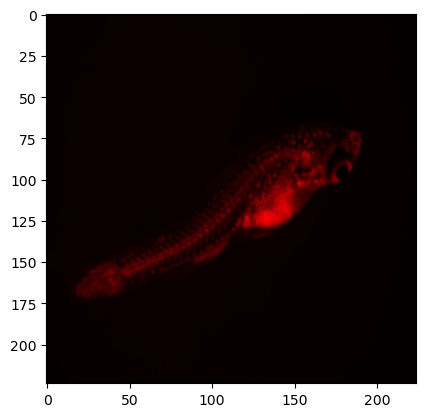

In [73]:
example = dataset[393]

print(example[0].shape)
plt.imshow(example[0].permute(1, 2, 0).cpu().numpy())

In [74]:
model.eval()
print(model(example[0].unsqueeze(0)).shape)

torch.Size([1, 128])


### Save the embedding vectors in a df

In [78]:
print(len(dataset))

1112


In [94]:
model.eval()
feature_matrix = {}
counter = 0

for image, image_name in dataset:
    embedding = model(image.unsqueeze(0))
    feature_matrix[image_name] = embedding.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110


KeyError: 1112

In [1]:
print(len(feature_matrix))
print(feature_matrix)

NameError: name 'feature_matrix' is not defined

In [101]:
print(feature_matrix['PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif'])

[ -77.71443    -61.410744    29.089512    41.218525    30.065296
  -10.29204    410.0883     -33.349293  -723.1503    -232.67517
  300.89902     20.10732    190.17273    540.12695   -176.24693
   44.52819    100.90983    308.12897    -52.166943   175.80885
 -321.41968    217.52153    526.3035    -365.1253     318.0609
 -209.16046    220.87271    370.936      224.94162    351.8649
  -27.167477   508.67697   -480.5968    -278.52948      4.4324927
  206.6029    -134.35341   -406.53784    346.28265    256.88086
 -181.99242    485.08722   -220.7049    -424.36957   -271.82516
  198.51367    281.1529    -357.6786      77.26173     87.08338
  274.8931    -343.04498    577.7297     516.1294    -364.40228
  136.5843     401.59244    151.21652    -59.072773   373.43015
  377.18597    -21.082111  -476.3881    -143.25397   -324.05157
  202.96922   -438.98062   -364.07556   -109.75923   -419.75226
  173.96829    399.22427     22.354723    10.570647  -542.5288
 -136.3367     360.90564    512.31586   

In [98]:
feature_df = pd.DataFrame.from_dict(feature_matrix, orient='index')
feature_df

feature_df.to_csv("/nfs/research/birney/users/esther/medaka-img/features/convnet-ae-pytorch-medaka/amber-sweep-1-epoch500-feature_matrix.csv")

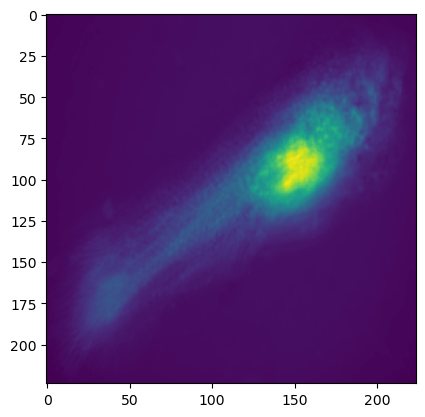

In [25]:
model.to(device)
model_output = model(train_example[0].reshape(-1, 224*224).to(device))

model_output = model_output.reshape(224, 224)
plt.imshow(model_output.cpu().detach().numpy())

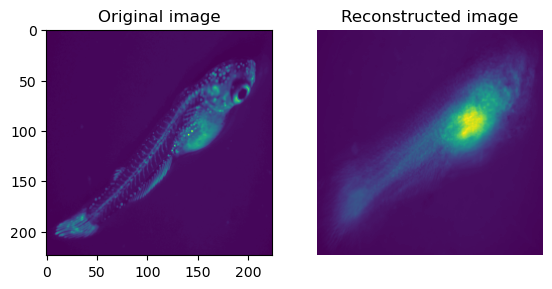

In [26]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')

axs[1].imshow(model_output.cpu().detach().numpy())
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

: 